In [ ]:
import cv2
import os
from os import listdir
import numpy as np

import random

from numpy import asarray, vstack, savez_compressed
from keras.utils import img_to_array, load_img

In [ ]:
## Drive path
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Path to the dataset
prepared_img = "/content/gdrive/MyDrive/Colab Notebooks/aivancity/Computer Vision/dataset/celeb_gan/celeb_256.npz"


We can load the prepared dataset and summarize the shape of each array, confirming our expectations of a  set of 256×256 image pairs.

In [ ]:
# load the prepared dataset
from numpy import load


# Path to save the prepared_img dataset
prepared_img = "/content/gdrive/MyDrive/Colab Notebooks/aivancity/Computer Vision/dataset/celeb_gan/celeb_256.npz"

# load the dataset
data = load(prepared_img)
real_images, cartoon_images = data['arr_0'], data['arr_1']
print('Loaded: ', real_images.shape, cartoon_images.shape)


Loaded:  (2001, 256, 256, 3) (2001, 256, 256, 3)


We can then plot some images pairs to confirm the data has been handled correctly.

A plot of 3 image pairs is also created showing the real images on the top and cartoon images on the bottom.



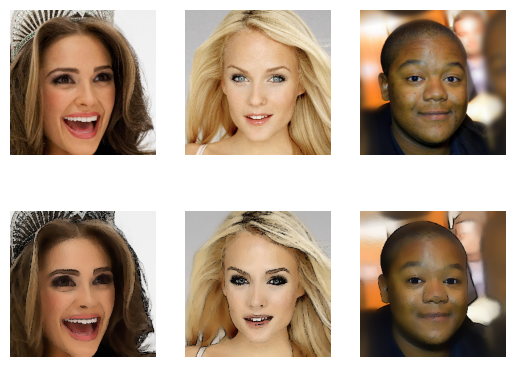

In [ ]:
from matplotlib import pyplot

# plot real images
n_samples = 3
for i in range(n_samples):
 pyplot.subplot(2, n_samples, 1 + i)
 pyplot.axis('off')
 pyplot.imshow(real_images[i].astype('uint8'))

# plot cartoon image
for i in range(n_samples):
 pyplot.subplot(2, n_samples, 1 + n_samples + i)
 pyplot.axis('off')
 pyplot.imshow(cartoon_images[i].astype('uint8'))

pyplot.show()

Now that we have prepared the dataset for image translation, we can develop our Pix2Pix GAN model.

### Develop and Train a Pix2Pix Model


The architecture is comprised of two models: the discriminator and the generator.

--------

The discriminator is a deep convolutional neural network that performs image classification. Specifically, conditional-image classification. It takes both the source image (e.g. real photo) and the target image (e.g. cartoon image) as input and predicts the likelihood of whether target image is real or a fake translation of the source image.

In [ ]:
# example of pix2pix gan for satellite to map image-to-image translation
from numpy import load, zeros, ones
from numpy.random import randint

from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, \
Concatenate, Dropout, BatchNormalization, LeakyReLU
from matplotlib import pyplot

In [ ]:
# define the discriminator model
def define_discriminator(image_shape):
 # weight initialization
 init = RandomNormal(stddev=0.02)
 
 # source image input
 in_src_image = Input(shape=image_shape)
 
 # target image input
 in_target_image = Input(shape=image_shape)
 
 # concatenate images channel-wise
 merged = Concatenate()([in_src_image, in_target_image])
 
 # C64
 d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
 d = LeakyReLU(alpha=0.2)(d)
 
 # C128
 d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 
 # C256
 d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 
 # C512
 d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 
 # second last output layer
 d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 
 # patch output
 d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
 patch_out = Activation('sigmoid')(d)
 
 # define model
 model = Model([in_src_image, in_target_image], patch_out)
 
 # compile model
 opt = Adam(lr=0.0002, beta_1=0.5)
 model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
 
 return model

In [ ]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  
  # add downsampling layer
  g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
  
  # conditionally add batch normalization
  if batchnorm:
    g = BatchNormalization()(g, training=True)
  
  # leaky relu activation
  g = LeakyReLU(alpha=0.2)(g)
  
  return g
 
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
  # weight initialization
  init = RandomNormal(stddev=0.02)

  # add upsampling layer
  g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)

  # add batch normalization
  g = BatchNormalization()(g, training=True)

  # conditionally add dropout
  if dropout:
    g = Dropout(0.5)(g, training=True)

  # merge with skip connection
  g = Concatenate()([g, skip_in])

  # relu activation
  g = Activation('relu')(g)

  return g
 
# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
  # weight initialization
  init = RandomNormal(stddev=0.02)

  # image input
  in_image = Input(shape=image_shape)

  # encoder model
  e1 = define_encoder_block(in_image, 64, batchnorm=False)
  e2 = define_encoder_block(e1, 128)
  e3 = define_encoder_block(e2, 256)
  e4 = define_encoder_block(e3, 512)
  e5 = define_encoder_block(e4, 512)
  e6 = define_encoder_block(e5, 512)
  e7 = define_encoder_block(e6, 512)

  # bottleneck, no batch norm and relu
  b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
  b = Activation('relu')(b)

  # decoder model
  d1 = decoder_block(b, e7, 512)
  d2 = decoder_block(d1, e6, 512)
  d3 = decoder_block(d2, e5, 512)
  d4 = decoder_block(d3, e4, 512, dropout=False)
  d5 = decoder_block(d4, e3, 256, dropout=False)
  d6 = decoder_block(d5, e2, 128, dropout=False)
  d7 = decoder_block(d6, e1, 64, dropout=False)

  # output
  g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
  out_image = Activation('tanh')(g)

  # define model
  model = Model(in_image, out_image)
  
  return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
  # make weights in the discriminator not trainable
  for layer in d_model.layers:
    if not isinstance(layer, BatchNormalization):
      layer.trainable = False

  # define the source image
  in_src = Input(shape=image_shape)

  # connect the source image to the generator input
  gen_out = g_model(in_src)

  # connect the source input and generator output to the discriminator input
  dis_out = d_model([in_src, gen_out])

  # src image as input, generated image and classification output
  model = Model(in_src, [dis_out, gen_out])
  
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
  
  return model

Next, we can load our paired images dataset in compressed NumPy array format.

This will return a list of two NumPy arrays: the first for source images and the second for corresponding target images.

In [ ]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
 
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']

	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
  
	return [X1, X2]

Training the discriminator will require batches of real and fake images.

The generate_real_samples() function below will prepare a batch of random pairs of images from the training dataset, and the corresponding discriminator label of class=1 to indicate they are real.

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
  # unpack dataset
  trainA, trainB = dataset

  # choose random instances
  ix = randint(0, trainA.shape[0], n_samples)

  # retrieve selected images
  X1, X2 = trainA[ix], trainB[ix]

  # generate 'real' class labels (1)
  y = ones((n_samples, patch_shape, patch_shape, 1))
  
  return [X1, X2], y